In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

class CatDogSVMClassifier:
    def __init__(self, img_size=(64, 64)):
        self.img_size = img_size
        self.model = svm.SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        self.scaler = StandardScaler()
        self.is_trained = False

    def preprocess_image(self, img_path):
        """Preprocess a single image"""
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is None:
                return None

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image
            img = cv2.resize(img, self.img_size)

            # Convert to grayscale for simpler features
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Flatten the image
            img_flattened = img_gray.flatten()

            return img_flattened

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None

    def load_training_data(self, train_folder):
        """Load training data from organized folders"""
        print("Loading training data...")

        X_train = []
        y_train = []

        # Assuming train_folder has subfolders: cats/ and dogs/
        cat_folder = os.path.join(train_folder, 'cats')
        dog_folder = os.path.join(train_folder, 'dogs')

        # Load cat images (label = 0)
        if os.path.exists(cat_folder):
            cat_files = glob(os.path.join(cat_folder, '*.jpg')) + glob(os.path.join(cat_folder, '*.jpeg'))
            for img_path in cat_files:
                processed_img = self.preprocess_image(img_path)
                if processed_img is not None:
                    X_train.append(processed_img)
                    y_train.append(0)  # 0 for cats

        # Load dog images (label = 1)
        if os.path.exists(dog_folder):
            dog_files = glob(os.path.join(dog_folder, '*.jpg')) + glob(os.path.join(dog_folder, '*.jpeg'))
            for img_path in dog_files:
                processed_img = self.preprocess_image(img_path)
                if processed_img is not None:
                    X_train.append(processed_img)
                    y_train.append(1)  # 1 for dogs

        print(f"Loaded {len(X_train)} training images ({sum(1 for y in y_train if y == 0)} cats, {sum(1 for y in y_train if y == 1)} dogs)")

        return np.array(X_train), np.array(y_train)

    def train(self, train_folder):
        """Train the SVM model"""
        # Load training data
        X_train, y_train = self.load_training_data(train_folder)

        if len(X_train) == 0:
            raise ValueError("No training data found. Make sure your train folder has 'cats' and 'dogs' subfolders with images.")

        print("Preprocessing training data...")
        # Scale the features
        X_train_scaled = self.scaler.fit_transform(X_train)

        print("Training SVM model...")
        # Train the SVM
        self.model.fit(X_train_scaled, y_train)
        self.is_trained = True

        print("Training completed!")

        # Return training accuracy
        train_pred = self.model.predict(X_train_scaled)
        train_accuracy = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_accuracy:.4f}")

        return train_accuracy

    def predict_test_folder(self, test_folder):
        """Predict labels for mixed test folder"""
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction!")

        print("Processing test images...")

        # Get all image files from test folder
        test_files = glob(os.path.join(test_folder, '*.jpg')) + glob(os.path.join(test_folder, '*.jpeg'))

        if not test_files:
            raise ValueError("No test images found in the specified folder!")

        predictions = []
        probabilities = []
        processed_files = []

        for img_path in test_files:
            processed_img = self.preprocess_image(img_path)
            if processed_img is not None:
                # Scale the features
                img_scaled = self.scaler.transform([processed_img])

                # Make prediction
                pred = self.model.predict(img_scaled)[0]
                prob = self.model.predict_proba(img_scaled)[0]

                predictions.append(pred)
                probabilities.append(max(prob))
                processed_files.append(img_path)

        return processed_files, predictions, probabilities

    def evaluate_with_labels(self, test_folder_with_labels):
        """Evaluate model when test folder has labeled subfolders"""
        if not self.is_trained:
            raise ValueError("Model must be trained before evaluation!")

        print("Loading test data for evaluation...")

        X_test = []
        y_test = []

        # Load test data similar to training data
        cat_folder = os.path.join(test_folder_with_labels, 'cats')
        dog_folder = os.path.join(test_folder_with_labels, 'dogs')

        # Load cat test images
        if os.path.exists(cat_folder):
            cat_files = glob(os.path.join(cat_folder, '*.jpg')) + glob(os.path.join(cat_folder, '*.jpeg'))
            for img_path in cat_files:
                processed_img = self.preprocess_image(img_path)
                if processed_img is not None:
                    X_test.append(processed_img)
                    y_test.append(0)

        # Load dog test images
        if os.path.exists(dog_folder):
            dog_files = glob(os.path.join(dog_folder, '*.jpg')) + glob(os.path.join(dog_folder, '*.jpeg'))
            for img_path in dog_files:
                processed_img = self.preprocess_image(img_path)
                if processed_img is not None:
                    X_test.append(processed_img)
                    y_test.append(1)

        if len(X_test) == 0:
            raise ValueError("No test data found!")

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Scale test data
        X_test_scaled = self.scaler.transform(X_test)

        # Make predictions
        y_pred = self.model.predict(X_test_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        return accuracy, y_pred, y_test

    def display_predictions(self, files, predictions, probabilities, num_samples=10):
        """Display sample predictions"""
        print(f"\nSample Predictions (showing first {num_samples}):")
        print("-" * 60)

        for i in range(min(num_samples, len(files))):
            filename = os.path.basename(files[i])
            label = "Dog" if predictions[i] == 1 else "Cat"
            confidence = probabilities[i]
            print(f"{filename}: {label} (confidence: {confidence:.3f})")

# Usage Example
def main():
    # Initialize classifier
    classifier = CatDogSVMClassifier(img_size=(64, 64))

    # Define paths (adjust these to your actual paths)
    train_folder = "/content/drive/MyDrive/dogsvscats/train"  # Should contain 'cats' and 'dogs' subfolders
    test_folder = "/content/drive/MyDrive/dogsvscats/test1"    # Mixed cats and dogs images

    try:
        # Train the model
        print("Starting training...")
        classifier.train(train_folder)

        # Make predictions on mixed test folder
        print("\nMaking predictions on test folder...")
        files, predictions, probabilities = classifier.predict_test_folder(test_folder)

        # Display results
        classifier.display_predictions(files, predictions, probabilities)

        # Save predictions to file
        with open('predictions.txt', 'w') as f:
            f.write("Filename,Prediction,Confidence\n")
            for i in range(len(files)):
                filename = os.path.basename(files[i])
                label = "Dog" if predictions[i] == 1 else "Cat"
                confidence = probabilities[i]
                f.write(f"{filename},{label},{confidence:.3f}\n")

        print(f"\nPredictions saved to 'predictions.txt'")
        print(f"Total images processed: {len(files)}")
        print(f"Cats predicted: {sum(1 for p in predictions if p == 0)}")
        print(f"Dogs predicted: {sum(1 for p in predictions if p == 1)}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Starting training...
Loading training data...
Loaded 25000 training images (12500 cats, 12500 dogs)
Preprocessing training data...
Training SVM model...


🐱🐶 Starting Optimized Cat vs Dog Classification
📊 Analyzing training data...


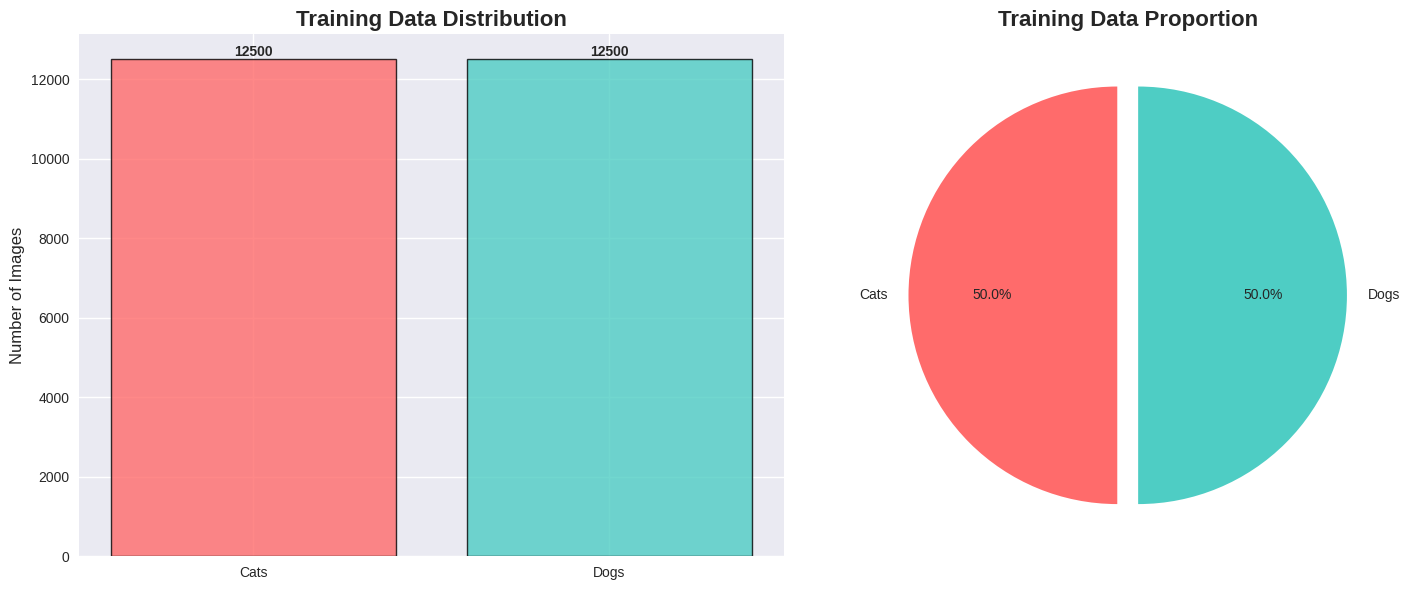

Total training images: 25000
Cats: 12500, Dogs: 12500


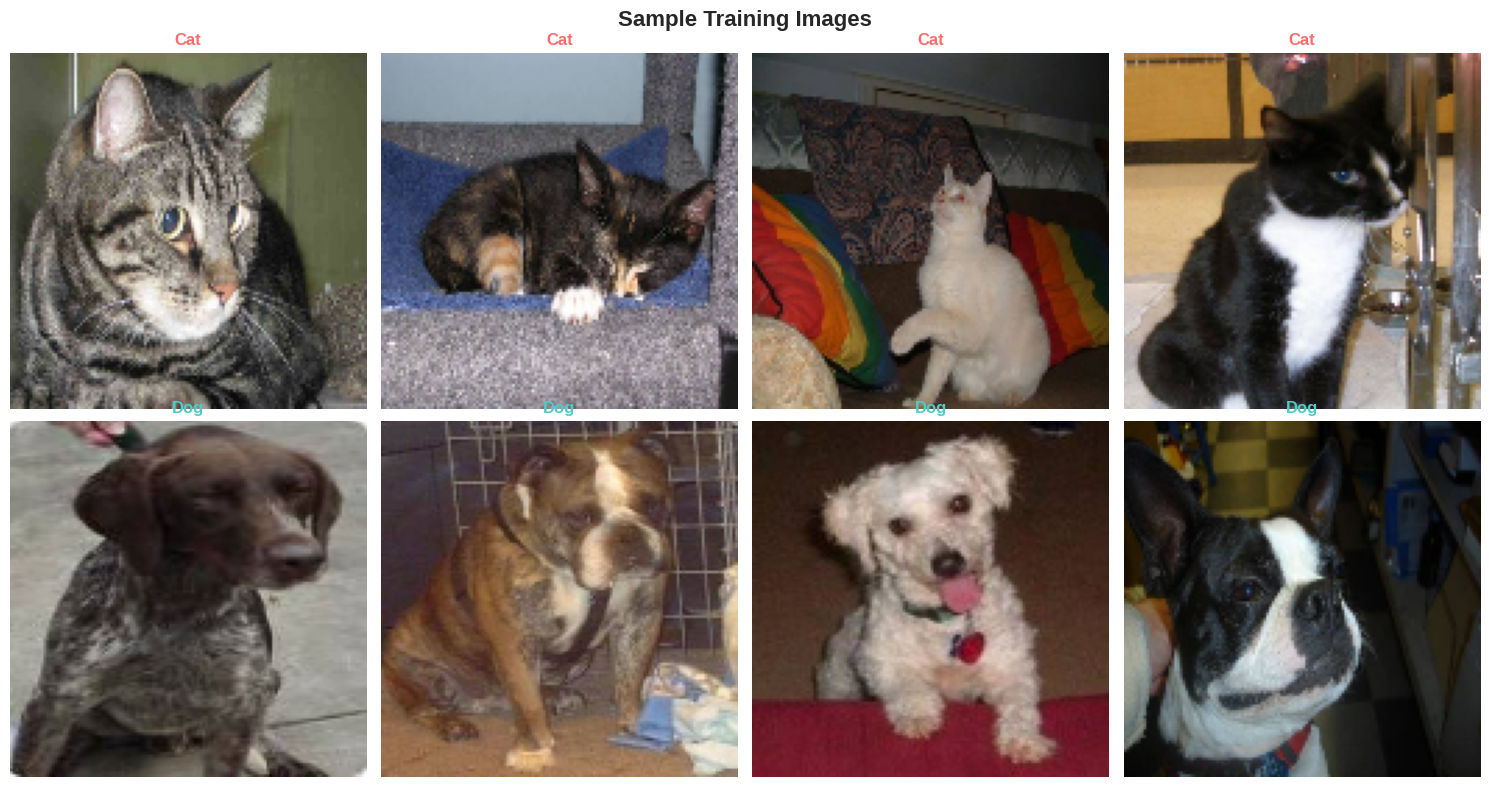

🏗️ Building model architecture...
Model built with 2,604,609 parameters
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
🚀 Starting training...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4308s 7s/step - accuracy: 0.6176 - loss: 0.8228 - val_accuracy: 0.6284 - val_loss: 0.6355 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1355s 2s/step - accuracy: 0.7104 - loss: 0.5564 - val_accuracy: 0.7258 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1286s 2s/step - accuracy: 0.7563 - loss: 0.4993 - val_accuracy: 0.7336 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.8019 - loss: 0.4344 - val_accuracy: 0.7154 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1341s 2s/step - accuracy: 0.8203 - loss: 0.3927 - val_accuracy: 0.6534 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1336s 2s/s

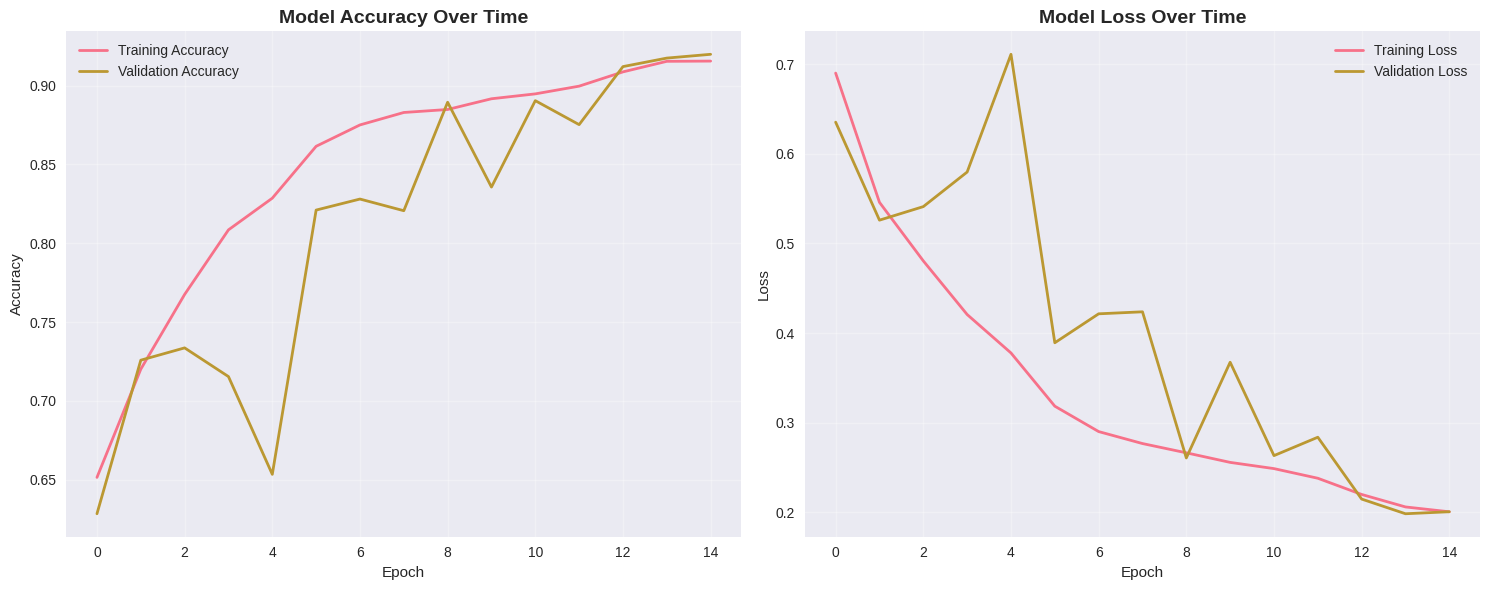


🔮 Making predictions on test images...
🔍 Processing test images...
📸 Displaying sample predictions...


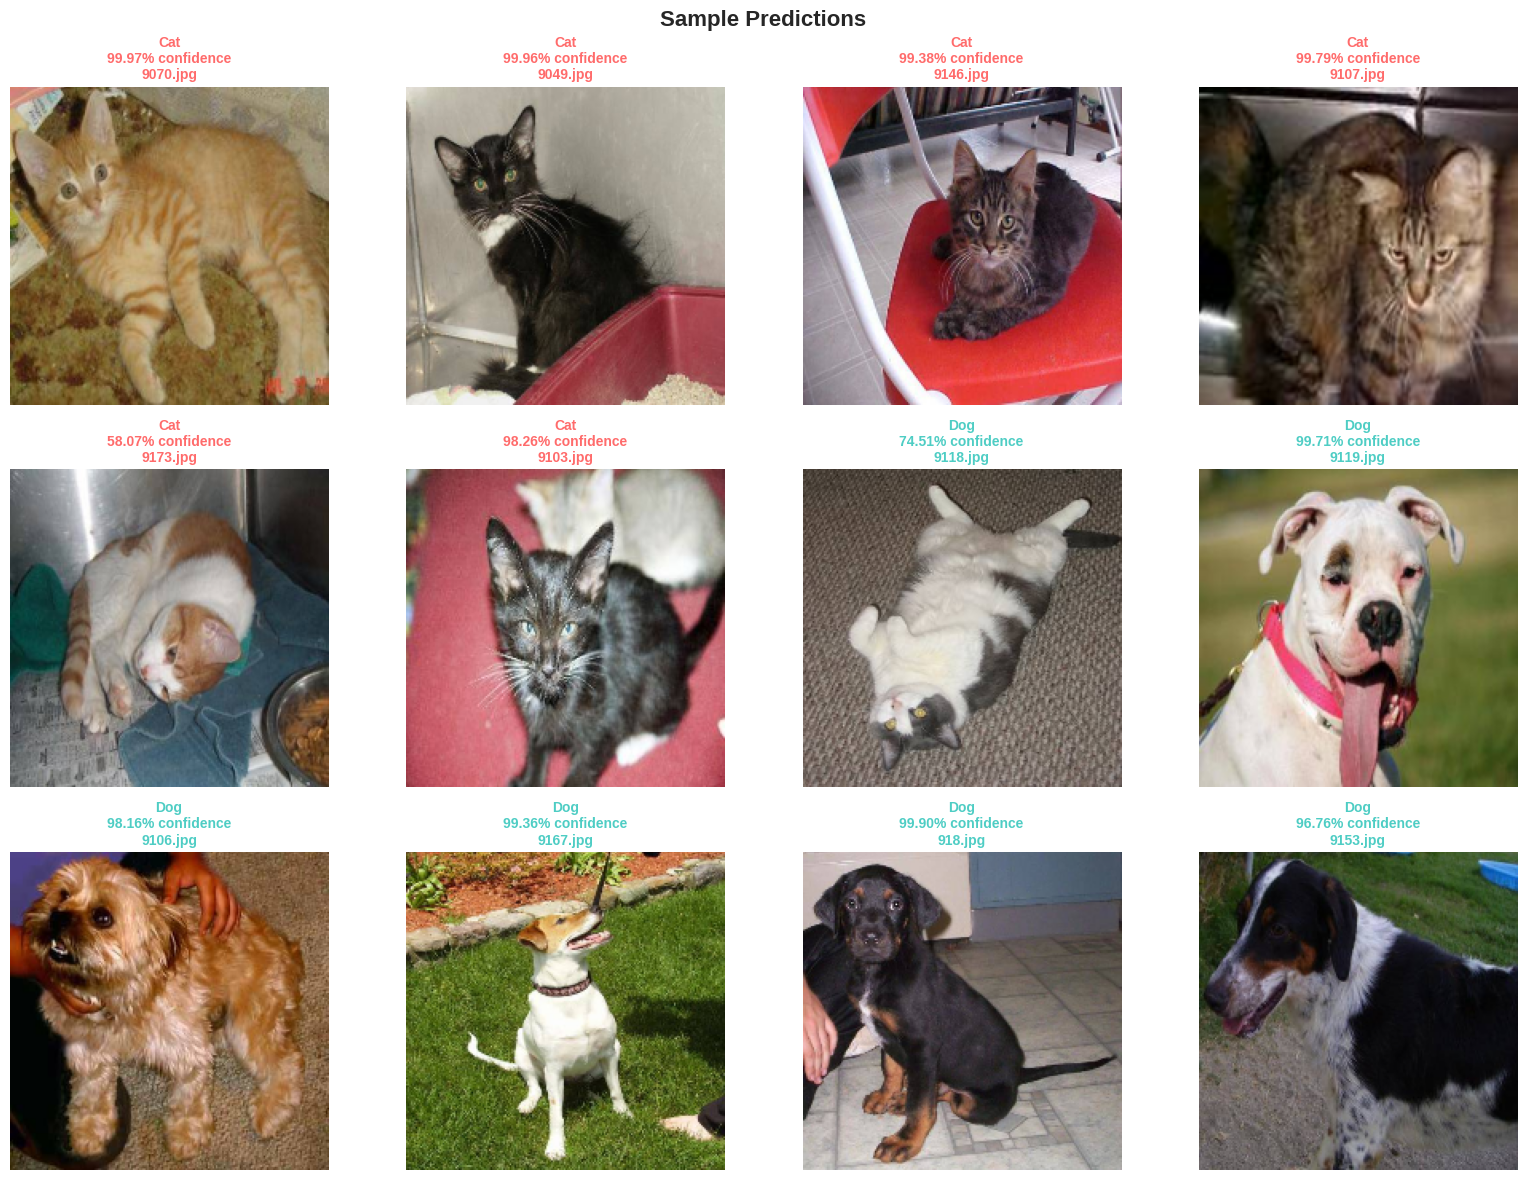

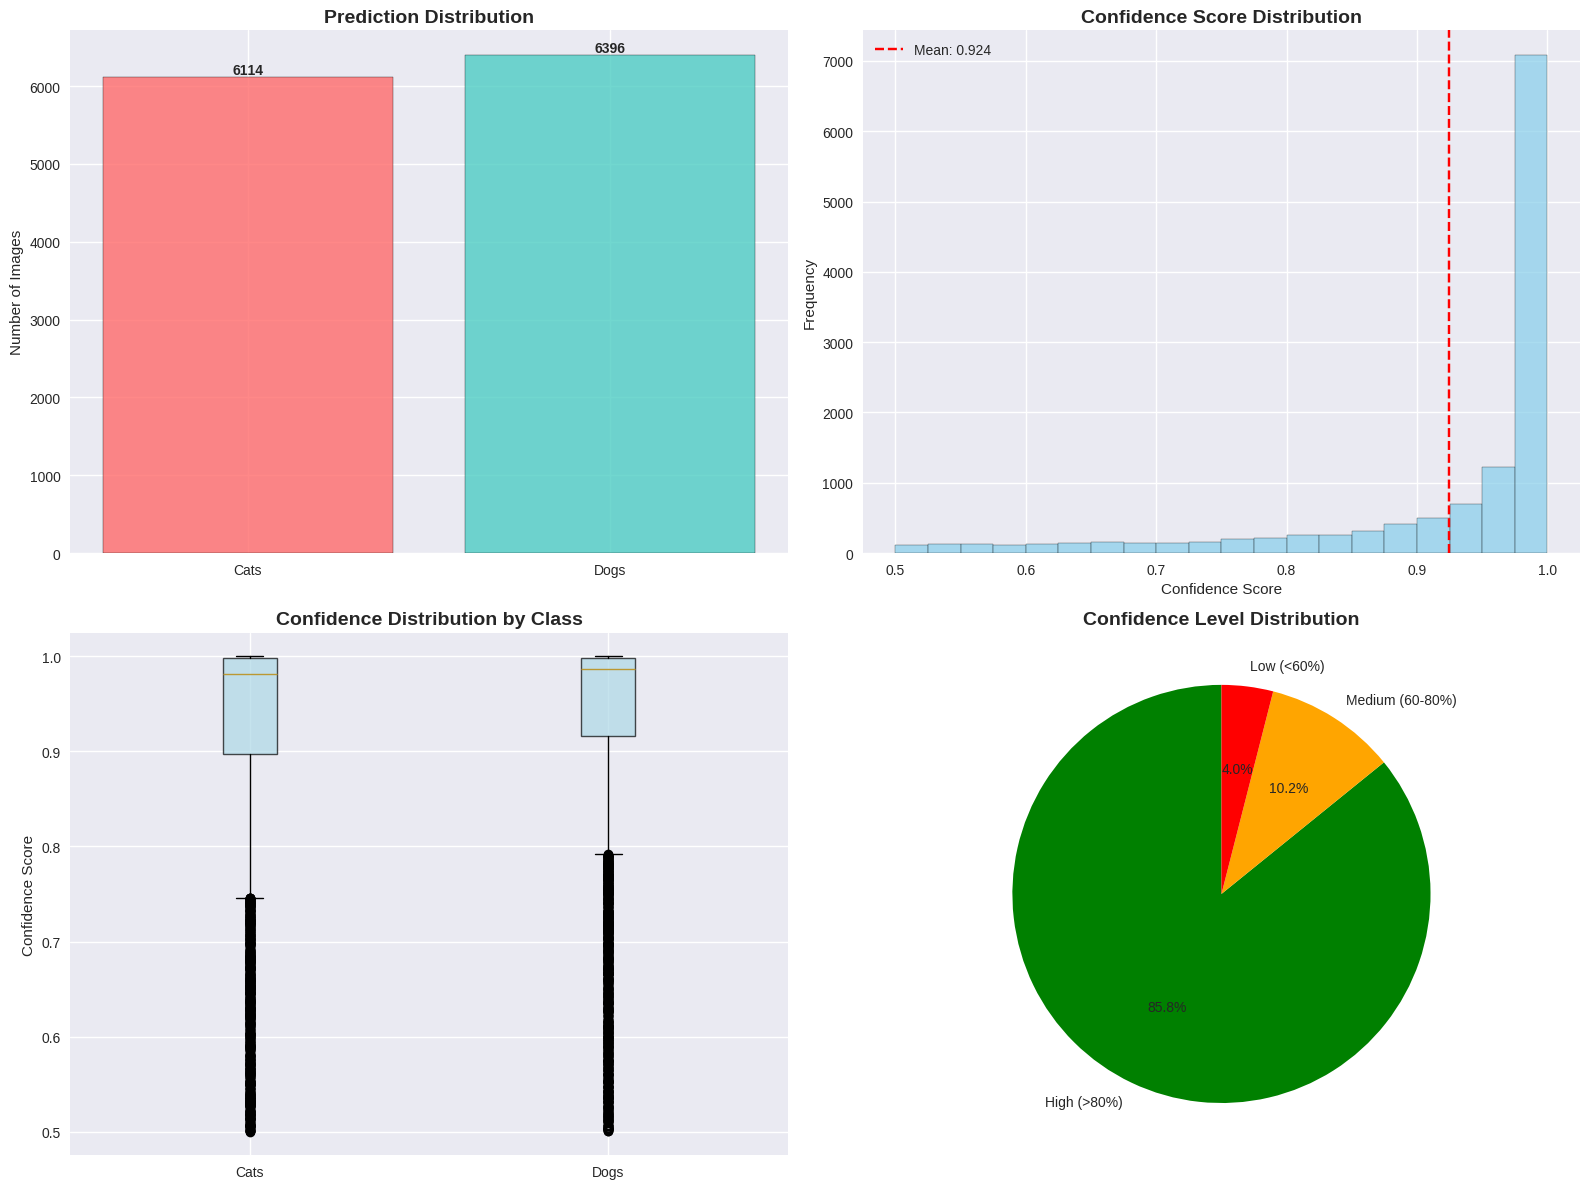


📊 Prediction Summary:
Total images processed: 12510
Cats predicted: 6114 (48.9%)
Dogs predicted: 6396 (51.1%)
Average confidence: 0.924
High confidence predictions (>80%): 10738 (85.8%)
💾 Results saved to 'predictions.csv'

✅ Classification completed successfully!
Check 'predictions.csv' for detailed results


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class OptimizedCatDogClassifier:
    def __init__(self, img_size=(128, 128), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        self.class_names = ['Cat', 'Dog']

        # Data augmentation for training
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            validation_split=0.2  # Use 20% for validation
        )

        # Only rescaling for test data
        self.test_datagen = ImageDataGenerator(rescale=1./255)

    def build_model(self):
        """Build an optimized CNN model"""
        model = keras.Sequential([
            # First Conv Block
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*self.img_size, 3)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),

            # Second Conv Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),

            # Third Conv Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),

            # Fourth Conv Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),

            # Flatten and Dense layers
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])

        # Compile with optimizer
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def visualize_data_distribution(self, train_folder):
        """Visualize the distribution of training data"""
        cat_folder = os.path.join(train_folder, 'cats')
        dog_folder = os.path.join(train_folder, 'dogs')

        cat_count = len(glob(os.path.join(cat_folder, '*.jpg')) + glob(os.path.join(cat_folder, '*.jpeg')))
        dog_count = len(glob(os.path.join(dog_folder, '*.jpg')) + glob(os.path.join(dog_folder, '*.jpeg')))

        # Create distribution plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot
        categories = ['Cats', 'Dogs']
        counts = [cat_count, dog_count]
        colors = ['#FF6B6B', '#4ECDC4']

        bars = ax1.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.set_title('Training Data Distribution', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Number of Images', fontsize=12)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    str(count), ha='center', va='bottom', fontweight='bold')

        # Pie chart
        ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%',
                startangle=90, explode=(0.05, 0.05))
        ax2.set_title('Training Data Proportion', fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"Total training images: {cat_count + dog_count}")
        print(f"Cats: {cat_count}, Dogs: {dog_count}")

        return cat_count, dog_count

    def show_sample_images(self, train_folder, num_samples=8):
        """Display sample images from training data"""
        cat_folder = os.path.join(train_folder, 'cats')
        dog_folder = os.path.join(train_folder, 'dogs')

        cat_files = glob(os.path.join(cat_folder, '*.jpg'))[:num_samples//2]
        dog_files = glob(os.path.join(dog_folder, '*.jpg'))[:num_samples//2]

        fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 8))
        fig.suptitle('Sample Training Images', fontsize=16, fontweight='bold')

        # Show cat images
        for i, img_path in enumerate(cat_files):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            axes[0, i].imshow(img)
            axes[0, i].set_title('Cat', fontweight='bold', color='#FF6B6B')
            axes[0, i].axis('off')

        # Show dog images
        for i, img_path in enumerate(dog_files):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            axes[1, i].imshow(img)
            axes[1, i].set_title('Dog', fontweight='bold', color='#4ECDC4')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def train(self, train_folder, epochs=15):
        """Train the CNN model with visualizations"""
        print("📊 Analyzing training data...")
        self.visualize_data_distribution(train_folder)
        self.show_sample_images(train_folder)

        # Build model
        print("🏗️ Building model architecture...")
        self.build_model()
        print(f"Model built with {self.model.count_params():,} parameters")

        # Prepare data generators
        train_generator = self.train_datagen.flow_from_directory(
            train_folder,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training'
        )

        validation_generator = self.train_datagen.flow_from_directory(
            train_folder,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation'
        )

        # Callbacks for optimization
        callbacks = [
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]

        print("🚀 Starting training...")
        start_time = time.time()

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")

        # Plot training history
        self.plot_training_history()

        return self.history

    def plot_training_history(self):
        """Plot training and validation metrics"""
        if self.history is None:
            print("No training history available!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        ax2.plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_test_folder(self, test_folder):
        """Predict labels for mixed test folder with optimized processing"""
        if self.model is None:
            raise ValueError("Model must be trained before prediction!")

        print("🔍 Processing test images...")
        test_files = glob(os.path.join(test_folder, '*.jpg')) + glob(os.path.join(test_folder, '*.jpeg'))

        if not test_files:
            raise ValueError("No test images found!")

        predictions = []
        probabilities = []
        processed_files = []

        # Process images in batches for efficiency
        batch_size = 32
        for i in range(0, len(test_files), batch_size):
            batch_files = test_files[i:i+batch_size]
            batch_images = []
            batch_valid_files = []

            for file_path in batch_files:
                try:
                    img = cv2.imread(file_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, self.img_size)
                        img = img / 255.0  # Normalize
                        batch_images.append(img)
                        batch_valid_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

            if batch_images:
                batch_array = np.array(batch_images)
                batch_preds = self.model.predict(batch_array, verbose=0)

                for j, pred_prob in enumerate(batch_preds):
                    prob = pred_prob[0]
                    pred_class = 1 if prob > 0.5 else 0

                    predictions.append(pred_class)
                    probabilities.append(prob if pred_class == 1 else 1 - prob)
                    processed_files.append(batch_valid_files[j])

        return processed_files, predictions, probabilities

    def visualize_predictions(self, files, predictions, probabilities, num_samples=12):
        """Visualize sample predictions with images"""
        print(f"📸 Displaying sample predictions...")

        # Select diverse samples (high and low confidence from both classes)
        cat_indices = [i for i, p in enumerate(predictions) if p == 0]
        dog_indices = [i for i, p in enumerate(predictions) if p == 1]

        # Get samples from each class
        sample_indices = []
        sample_indices.extend(cat_indices[:num_samples//2])
        sample_indices.extend(dog_indices[:num_samples//2])
        sample_indices = sample_indices[:num_samples]

        if len(sample_indices) < num_samples:
            sample_indices = list(range(min(num_samples, len(files))))

        rows = 3
        cols = 4
        fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
        fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

        for i, idx in enumerate(sample_indices):
            if i >= rows * cols:
                break

            row = i // cols
            col = i % cols

            # Load and display image
            img = cv2.imread(files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (200, 200))

            axes[row, col].imshow(img)

            # Create title with prediction
            pred_label = self.class_names[predictions[idx]]
            confidence = probabilities[idx]
            filename = os.path.basename(files[idx])

            color = '#4ECDC4' if predictions[idx] == 1 else '#FF6B6B'
            title = f"{pred_label}\n{confidence:.2%} confidence\n{filename[:15]}"

            axes[row, col].set_title(title, fontsize=10, fontweight='bold', color=color)
            axes[row, col].axis('off')

        # Hide empty subplots
        for i in range(len(sample_indices), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_prediction_analysis(self, predictions, probabilities):
        """Create analysis plots for predictions"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Prediction distribution
        pred_counts = [predictions.count(0), predictions.count(1)]
        colors = ['#FF6B6B', '#4ECDC4']

        bars = ax1.bar(['Cats', 'Dogs'], pred_counts, color=colors, alpha=0.8, edgecolor='black')
        ax1.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Images')

        for bar, count in zip(bars, pred_counts):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(count), ha='center', va='bottom', fontweight='bold')

        # 2. Confidence distribution
        ax2.hist(probabilities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Confidence Score')
        ax2.set_ylabel('Frequency')
        ax2.axvline(np.mean(probabilities), color='red', linestyle='--',
                   label=f'Mean: {np.mean(probabilities):.3f}')
        ax2.legend()

        # 3. Confidence by class
        cat_probs = [probabilities[i] for i, p in enumerate(predictions) if p == 0]
        dog_probs = [probabilities[i] for i, p in enumerate(predictions) if p == 1]

        ax3.boxplot([cat_probs, dog_probs], labels=['Cats', 'Dogs'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
        ax3.set_title('Confidence Distribution by Class', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Confidence Score')

        # 4. High/Low confidence breakdown
        high_conf = sum(1 for p in probabilities if p > 0.8)
        med_conf = sum(1 for p in probabilities if 0.6 <= p <= 0.8)
        low_conf = sum(1 for p in probabilities if p < 0.6)

        wedges, texts, autotexts = ax4.pie([high_conf, med_conf, low_conf],
                                          labels=['High (>80%)', 'Medium (60-80%)', 'Low (<60%)'],
                                          colors=['green', 'orange', 'red'],
                                          autopct='%1.1f%%', startangle=90)
        ax4.set_title('Confidence Level Distribution', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\n📊 Prediction Summary:")
        print(f"Total images processed: {len(predictions)}")
        print(f"Cats predicted: {pred_counts[0]} ({pred_counts[0]/len(predictions)*100:.1f}%)")
        print(f"Dogs predicted: {pred_counts[1]} ({pred_counts[1]/len(predictions)*100:.1f}%)")
        print(f"Average confidence: {np.mean(probabilities):.3f}")
        print(f"High confidence predictions (>80%): {high_conf} ({high_conf/len(predictions)*100:.1f}%)")

    def save_results(self, files, predictions, probabilities, output_file='predictions.csv'):
        """Save predictions to CSV with enhanced information"""
        results = []
        for i in range(len(files)):
            filename = os.path.basename(files[i])
            pred_label = self.class_names[predictions[i]]
            confidence = probabilities[i]

            results.append({
                'filename': filename,
                'prediction': pred_label,
                'confidence': f"{confidence:.4f}",
                'confidence_percent': f"{confidence*100:.2f}%"
            })

        df = pd.DataFrame(results)
        df.to_csv(output_file, index=False)
        print(f"💾 Results saved to '{output_file}'")

        return df

# Main execution function
def main():
    # Initialize classifier with optimized settings
    classifier = OptimizedCatDogClassifier(img_size=(128, 128), batch_size=32)

    # Define your paths here
    train_folder = "/content/drive/MyDrive/dogsvscats/train"  # Should contain 'cats' and 'dogs' subfolders
    test_folder = "/content/drive/MyDrive/dogsvscats/test1"

    try:
        print("🐱🐶 Starting Optimized Cat vs Dog Classification")
        print("=" * 50)

        # Train the model
        classifier.train(train_folder, epochs=15)

        # Make predictions
        print("\n🔮 Making predictions on test images...")
        files, predictions, probabilities = classifier.predict_test_folder(test_folder)

        # Visualize results
        classifier.visualize_predictions(files, predictions, probabilities)
        classifier.plot_prediction_analysis(predictions, probabilities)

        # Save results
        results_df = classifier.save_results(files, predictions, probabilities)

        print("\n✅ Classification completed successfully!")
        print(f"Check 'predictions.csv' for detailed results")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure your folder structure is correct:")
        print("train_folder/")
        print("├── cats/")
        print("│   └── *.jpg")
        print("└── dogs/")
        print("    └── *.jpg")

if __name__ == "__main__":
    main()